# Eternal Module Installations

In [ ]:
! pip install openbiolink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 226 kB 15.7 MB/s 


In [ ]:
pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 14.2 MB/s 
     |████████████████████████████████| 3.5 MB 325 kB/s 
     |████████████████████████████████| 2.4 MB 60.2 MB/s 
     |████████████████████████████████| 750 kB 56.6 MB/s 
     |████████████████████████████████| 467 kB 14.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=2faf5516dca61b9fc99210b0ec743fa4ba0ca0e06e128786e060bc2e2d983b82
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [ ]:
#@title
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install torch-geometric

In [ ]:
#@title
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
# !pip install torch-geometric

In [ ]:
#@title
# #@title
# ! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html

In [ ]:
#@title
# import torch

# def format_pytorch_version(version):
#     return version.split('+')[0]

# def format_cuda_version(version):
#     return 'cu' + version.replace('.', '')

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)
# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric
# !pip install torch_geometric

# Module Imports

In [ ]:
from openbiolink.obl2021 import OBL2021Dataset, OBL2021Evaluator
import torch
from torch.nn import Module,\
                     ModuleList,\
                     Embedding,\
                     BatchNorm1d,\
                     ReLU,\
                     Linear,\
                     BCEWithLogitsLoss,\
                     MarginRankingLoss,\
                     CrossEntropyLoss,\
                     Dropout
from torch.optim import Adam
import torch.nn.functional as F
import torch_geometric as PyG
from torch_geometric.data import Data
from torch_geometric.nn.conv import RGCNConv
# from torch_geometric.utils import to_networkx
# import networkx as nx
# import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import NoReturn
import typing
# import time
from enum import Enum
# from datetime import datetime
# from collections import defaultdict

OSError: ignored

# Dataset Loading + Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/ProjectI

/content/drive/MyDrive/ProjectI


In [ ]:
dataset = OBL2021Dataset()
evaluator = OBL2021Evaluator()
# kg = torch.cat((dataset.training, dataset.validation, dataset.testing), dim=0)
entities = dataset.candidates
train_set = dataset.training
dev_set = dataset.validation
test_set = dataset.testing

Dataset found in /content/drive/MyDrive/ProjectI/obl2021, omitting download...


In [ ]:
dataset.stats

'# Triples:     \n     Train 4192002\n     Valid 186301\n     Test  180964\n# Relations:   28\n# Entities:    180992\n'

# Models

## DistMult

In [ ]:
class DistMultModel(Module):
  def __init__(self, num_entities: int, num_relations: int, embedding_size: int) -> NoReturn:
    super(DistMultModel, self).__init__()
    self.num_entities = num_entities
    self.num_relations = num_relations
    self.embedding_size = embedding_size
    self.entity_encoder = Embedding(self.num_entities, self.embedding_size)
    self.relation_encoder = Embedding(self.num_relations, self.embedding_size)

  def _encode_triplets(self, triplets: torch.Tensor) -> tuple:
    h_heads = self.entity_encoder(triplets[:, 0])
    h_tails = self.entity_encoder(triplets[:, 2])
    h_relations = self.relation_encoder(triplets[:, 1])
    return h_heads, h_relations, h_tails

  def forward(self, data_triplets: tuple((torch.Tensor, torch.Tensor))) -> tuple:
    p_triplets, n_triplets = data_triplets
    p_heads, p_relations, p_tails = self._encode_triplets(p_triplets)
    n_heads, n_relations, n_tails = self._encode_triplets(n_triplets)

    p_scores = (p_heads * p_relations * p_tails).sum(-1)
    n_scores = (n_heads * n_relations * n_tails).sum(-1)

    return p_scores, n_scores

## RESCAL

In [ ]:
class RESCALModel(Module):
  def __init__(self, num_entities: int, num_relations: int, embedding_size: int) -> NoReturn:
    super(RESCALModel, self).__init__()
    self.num_entities = num_entities
    self.num_relations = num_relations
    self.embedding_size = embedding_size
    self.entity_encoder = Embedding(self.num_entities, self.embedding_size)
    self.relation_encoder = Embedding(self.num_relations, self.embedding_size * self.embedding_size)

  def _encode_triplets(self, triplets: torch.Tensor) -> tuple:
    h_heads = self.entity_encoder(triplets[:, 0])
    h_tails = self.entity_encoder(triplets[:, 2])
    h_relations = self.relation_encoder(triplets[:, 1]).reshape(-1, self.embedding_size, self.embedding_size)
    return h_heads, h_relations, h_tails

  def forward(self, data_triplets: tuple((torch.Tensor, torch.Tensor))) -> tuple:
    p_triplets, n_triplets = data_triplets
    p_heads, p_relations, p_tails = self._encode_triplets(p_triplets)
    n_heads, n_relations, n_tails = self._encode_triplets(n_triplets)

    n_scores = torch.matmul(
        torch.matmul(n_heads.reshape(-1, 1, self.embedding_size), n_relations),
        n_tails.reshape(-1, self.embedding_size, 1)
    )

    p_scores = torch.matmul(
        torch.matmul(p_heads.reshape(-1, 1, self.embedding_size), p_relations),
        p_tails.reshape(-1, self.embedding_size, 1)
    )

    return p_scores.reshape(-1), n_scores.reshape(-1)

## Hinge Loss

In [ ]:
class HingeLoss(Module):
  def __init__(self, margin):
    super(HingeLoss, self).__init__()
    self.margin = margin
    self.loss_fn = MarginRankingLoss(self.margin)

  def forward(self, p_scores: torch.Tensor, n_scores: torch.Tensor) -> torch.Tensor:
    positive = p_scores.repeat(n_scores.shape)
    negative = n_scores.repeat(p_scores.shape)

    return self.loss_fn(positive, negative, torch.ones(n_scores.shape[0] * p_scores.shape[0]).to(positive.device))


## Graph Neural Network

In [ ]:
class GNN(Module):
  def __init__(self, num_entities: int, num_relations: int, embedding_dim: int, conv_dims: tuple, dropout, num_bases=None, num_blocks=None):
    super(GNN, self).__init__()
    self.num_entities = num_entities
    self.num_relations = num_relations
    self.embedding_dim = embedding_dim 
    self.conv_channels = [self.embedding_dim] + list(conv_dims)
    self.dropout = dropout

    self.shallow_embedding = Embedding(self.num_entities, self.embedding_dim)
    self.relation_embedding = Embedding(self.num_relations, self.conv_channels[-1])
    self.emb_bn = BatchNorm1d(self.embedding_dim)
    self.conv = ModuleList([
                RGCNConv(dim, self.conv_channels[index + 1], num_relations=self.num_relations, num_bases=num_bases, num_blocks=num_blocks)
                for index, dim in enumerate(self.conv_channels[:-1])
    ])
    self.conv_bn = ModuleList([
                        BatchNorm1d(dim)
                        for dim in self.conv_channels[1:]
    ])
    self.activation = ReLU()
    self.dropout = Dropout(p=self.dropout)

  def _node_encoder(self, data: Data):
    x = data.x
    x = self.shallow_embedding(x)
    x = self.emb_bn(x)
    x = self.dropout(x)
    for conv, conv_bn in zip(self.conv, self.conv_bn):
      x = conv(x, data.edge_index, data.edge_type) 
      x = conv_bn(x)
      x = self.activation(x)
      x = self.dropout(x)
    return x

  def _triplet_decoder(self, encoded, triplets):
    heads = encoded[triplets[:, 0]]
    relations = self.relation_embedding(triplets[:, 1])

    #relations = self.dropout(relations)

    tails = encoded[triplets[:, 2]]
    return (heads * relations * tails).sum(-1)
  
  def forward(self, data: Data):
    nodes_h = self._node_encoder(data)
    ## decoding part of the auto-encoder
    p_scores = self._triplet_decoder(nodes_h, data.positive)
    n_scores = self._triplet_decoder(nodes_h, data.negative)
    return p_scores, n_scores


# Graph Miner

In [ ]:
class GraphMiner():
  def __init__(self, dataset, device: str, cache_size: int=None, replacement_size: int=None) -> NoReturn:
    self.device = device
    self.dataset = dataset
    self.training = self.dataset.training.to(self.device)
    self.validation = self.dataset.validation.to(self.device)
    self.testing = self.dataset.testing.to(self.device)
    self.candidates = self.dataset.candidates.to(self.device)
    if cache_size and replacement_size:
      self.cache_size = cache_size
      self.replacement_size = replacement_size
      self.head_cache = (torch.rand(dataset.num_relations, entities.shape[0], cache_size) * entities.shape[0] - 1).round().long().to(self.device)
      self.tail_cache = (torch.rand(entities.shape[0], dataset.num_relations, cache_size) * entities.shape[0] - 1).round().long().to(self.device)

    self.num_entities = self.dataset.num_entities
    self.num_relations = self.dataset.num_relations

  def pyg_data(self, index, batch_size, negative_sampler):
    indcs = torch.ones_like(self.training[:, 0], dtype=torch.bool)
    not_include = torch.arange(index, index + batch_size, device=self.device)
    indcs[not_include] = False

    edge_index = self.training[indcs][:, (0, 2)].t().contiguous()
    edge_type = self.training[indcs][:, 1].t().contiguous()
    positive = self.training[index: index + batch_size, :]
    negative = negative_sampler(positive)

    return Data(
        x=self.candidates,
        edge_index=edge_index,
        edge_type=edge_type,
        positive=positive,
        negative=negative
    )

  def uniform_negative_sample(self, batch):
    batch_size = batch.shape[0]

    head_relation = batch[:, (0, 1)].repeat(self.candidates.shape[0], 1)
    relation_tail = batch[:, (1, 2)].repeat(self.candidates.shape[0], 1)

    entities = self.candidates.reshape(-1, 1).repeat(batch_size, 1)
    entities = torch.cat(torch.split(entities, self.candidates.shape[0]), -1).reshape(-1, 1)

    corrupted_head_triplets = torch.cat(
        (entities, relation_tail), 
        -1
    )
    corrupted_tail_triplets = torch.cat(
        (head_relation, entities), 
        -1
    )

    negative_triplets = torch.cat((corrupted_head_triplets, corrupted_tail_triplets))
    negative_triplets = torch.cat(torch.split(negative_triplets, batch_size), -1).reshape(batch_size, -1, 3)
    indcs = (torch.rand(batch_size) * (self.candidates.shape[0] * 2 - 1)).round().long().to(self.device)
    splits = torch.split(negative_triplets.reshape(-1, 3), self.candidates.shape[0] * 2)
    splits = torch.stack(splits).reshape(-1, 3)

    indcs += torch.arange(batch_size).to(self.device) * (2 * self.candidates.shape[0])
    negative_samples = splits[indcs]
    return negative_samples

  def cache_negative_sample(self, batch):
    batch_size = batch.shape[0]
    heads = batch[:, 0]
    tails = batch[:, 2]
    relations = batch[:, 1]

    candidate_heads = self.head_cache[relations, tails]
    candidate_tails = self.tail_cache[heads, relations]

    corrupt_head_indcs = (torch.rand(batch_size) * (self.cache_size - 1)).round().long().to(self.device) # 1 for each item in the batch?
    corrupt_tail_indcs = (torch.rand(batch_size) * (self.cache_size - 1)).round().long().to(self.device) # 1 for each item in the batch?

    corrupt_head_indcs += torch.arange(batch_size).to(self.device) * self.cache_size
    corrupt_heads = candidate_heads.reshape(-1)[corrupt_head_indcs]

    corrupt_tail_indcs += torch.arange(batch_size).to(self.device) * self.cache_size
    corrupt_tails = candidate_tails.reshape(-1)[corrupt_tail_indcs]

    corrupted_head_triplets = torch.cat((corrupt_heads.reshape(-1, 1), batch[:, (1, 2)]), -1)
    corrupted_tail_triplets = torch.cat((batch[:, (0, 1)], corrupt_tails.reshape(-1, 1)), -1)
    negative_triplets = torch.cat((corrupted_head_triplets, corrupted_tail_triplets), 0)

    negative_triplets = torch.cat(torch.split(negative_triplets, batch_size), -1).reshape(batch_size, -1, 3)
    indcs = torch.rand(batch_size).round().long().to(self.device)
    splits = torch.split(negative_triplets.reshape(-1, 3), 1 * 2)

    splits = torch.stack(splits).reshape(-1, 3)
    indcs += torch.arange(batch_size).to(self.device) * (1 * 2)
    negative_samples = splits[indcs]
    # self.update_caches(batch, scoring_function)
    return negative_samples

  def _update_cache(self, batch, scoring_function, head_or_tail, **kwargs):
    if kwargs.get('gnn'):
      data = batch
      batch = data.positive
    batch_size = batch.shape[0]
    heads = batch[:, 0]
    tails = batch[:, 2]
    relations = batch[:, 1]

    replacement_candidates = (
          torch.rand(
              batch_size * self.replacement_size
          ) * (self.candidates.shape[0] - 1)).round().long().reshape(batch_size, self.replacement_size).to(self.device)

    if head_or_tail == 'head':
      current_entities = self.head_cache[relations, tails]
    elif head_or_tail == 'tail':
      current_entities = self.tail_cache[heads, relations]

    entities_pool = torch.cat((current_entities, replacement_candidates), -1)
    if head_or_tail == 'head':
      partial_triplets = batch[:, 1:]
    elif head_or_tail == 'tail':
      partial_triplets = batch[:, :2]
    partial_triplets = partial_triplets.repeat(entities_pool.shape[1], 1)

    partial_triplets = torch.cat(torch.split(partial_triplets, batch_size), -1).reshape(batch_size, -1, 2).reshape(-1, 2)

    if head_or_tail == 'head':
      pool = torch.cat((entities_pool.reshape(-1, 1), partial_triplets), -1)
    elif head_or_tail == 'tail':
      pool = torch.cat((partial_triplets, entities_pool.reshape(-1, 1)), -1)

    dummy = torch.ones(1, 3).long().to(self.device)
    input = (pool, dummy)
    if kwargs.get('gnn'):
      input = Data(
              edge_index=data.edge_index,
               edge_type=data.edge_type,
               x=data.x,
               positive=pool,
               negative=dummy
          )
      
    scoring_function.eval()
    with torch.no_grad():
      scores = scoring_function(input)[0]
    
    fitness = F.softmax(scores, 0)
    split = torch.stack(torch.split(fitness, self.replacement_size + self.cache_size))

    next_entities_indcs = split.multinomial(num_samples=self.cache_size)
    if head_or_tail == 'head':
      self.head_cache[relations, tails] = torch.take(entities_pool, next_entities_indcs)
    elif head_or_tail == 'tail':
      self.tail_cache[heads, relations] = torch.take(entities_pool, next_entities_indcs)

  def update_caches(self, batch, scoring_function, **kwargs):
    self._update_cache(batch, scoring_function, 'head', **kwargs)
    self._update_cache(batch, scoring_function, 'tail', **kwargs)

  def train(self, model: Module, data, optimizer: torch.optim, loss_fn, update_cache=False) -> tuple((torch.float, torch.Tensor, torch.Tensor)):
    optimizer.zero_grad()
    model.train()

    positive, negative = model(data) # forward pass

    loss = loss_fn(positive, negative) # margin ranking loss

    loss.backward() # back propagation
    optimizer.step() # parameter updates
    if update_cache:
      self.update_caches(data, model, gnn=True)
    return loss.item()

  @torch.no_grad()
  def _ranks(self, model, batch, **kwargs):
    if kwargs.get('gnn'):
      data = batch
      batch = data.positive
    batch_size = batch.shape[0]

    head_relation = batch[:, (0, 1)].repeat(self.candidates.shape[0], 1)
    relation_tail = batch[:, (1, 2)].repeat(self.candidates.shape[0], 1)

    entities = self.candidates.reshape(-1, 1).repeat(batch_size, 1)
    entities = torch.cat(torch.split(entities, self.candidates.shape[0]), -1).reshape(-1, 1)

    corrupted_head_triplets = torch.cat(
        (entities, relation_tail), 
        -1
    )
    corrupted_tail_triplets = torch.cat(
        (head_relation, entities), 
        -1
    )
    corrupted_head_triplets = torch.cat(torch.split(corrupted_head_triplets, batch_size), -1).reshape(batch_size, -1, 3)
    corrupted_tail_triplets = torch.cat(torch.split(corrupted_tail_triplets, batch_size), -1).reshape(batch_size, -1, 3)

    heads = batch[:, 0]
    tails = batch[:, 2]

    dummy = torch.ones(1, 3).long().to(self.device)
    input = corrupted_head_triplets.reshape(-1, 3)
    if kwargs.get('gnn'):
      input = Data(
              edge_index=data.edge_index,
               edge_type=data.edge_type,
               x=data.x,
               positive=input,
               negative=dummy
          )
    else:
      input = (input, dummy)
    model.eval()
    head_scores = model(
        input
    )[0].reshape(batch_size, -1)
    head_ranks = (head_scores.gather(dim=1, index=heads.reshape(-1, 1)) <= head_scores).sum(-1) # Max Policy

    input = corrupted_tail_triplets.reshape(-1, 3)
    if kwargs.get('gnn'):
      input = Data(
              edge_index=data.edge_index,
               edge_type=data.edge_type,
               x=data.x,
               positive=input,
               negative=dummy
          )
    else:
      input = (input, dummy)
    tail_scores = model(
        input
    )[0].reshape(batch_size, -1)
    tail_ranks = (tail_scores.gather(dim=1, index=tails.reshape(-1, 1)) <= tail_scores).sum(-1)

    return head_ranks.reshape(-1), tail_ranks.reshape(-1)

  @torch.no_grad()
  def MRR(self, model, set_type, batch_size, use_tqdm=False, **kwargs):
    if set_type == 'validation':
      eval_set = self.validation
      if kwargs.get('gnn'):
        message = self.training
    elif set_type == 'testing':
      eval_set = self.testing
      if kwargs.get('gnn'):
        message = torch.cat((self.training, self.validation), 0)
    else:
      raise ValueError('Wrong data split specified.')
    
    sum = 0
    size = 0

    wrapper = tqdm if use_tqdm else (lambda z: z)
    for batch in wrapper(torch.split(eval_set, batch_size)):
      if kwargs.get('gnn'):
        batch = Data(
            edge_index=message[:, (0, 2)].t().contiguous(),
            edge_type=message[:, 1].t().contiguous(),
            x=self.candidates,
            positive=batch
        )
      head_ranks, tail_ranks = self._ranks(model, batch, **kwargs)
      sum += (1 / head_ranks).sum() + (1 / tail_ranks).sum()
      size += head_ranks.shape[0] + tail_ranks.shape[0]
    return sum / size

    
      

# Modeling

## GNN

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gm = GraphMiner(dataset, device, 50, 50)
gm.head_cache = torch.load('head.pt').to(device)
gm.tail_cache = torch.load('tail.pt').to(device)
# gnn = GNN(gm.num_entities, gm.num_relations, 32, (32, 16, 16), 0.4, num_bases=7).to(device)
gnn = torch.load('gnn.pth').to(device)

print(gnn)
optimizer = Adam(gnn.parameters())
margin = 1
criterion = HingeLoss(margin=margin)
batch_size = 256
num_epochs = 10
where_i = 0
where_epoch = 0
what_loss = 0

In [ ]:
with open('where.txt') as fp:
  args = fp.read().split(', ')
  where_i = int(args[0])
  where_epoch = int(args[1])
  what_loss = float(args[2])
print(where_i, where_epoch, what_loss)

128000 5 68.99426233023405


In [ ]:
# gm.training = gm.training[torch.randperm(gm.training.shape[0])]
for epoch in range(where_epoch, num_epochs):
  epoch_loss = what_loss

  for i in tqdm(range(where_i, gm.training.shape[0], batch_size)):
    if i + batch_size > gm.training.shape[0]:
      continue
    train_data = gm.pyg_data(i, batch_size, gm.cache_negative_sample)
    batch_loss = gm.train(gnn, train_data, optimizer, criterion, True)
    epoch_loss += batch_loss
    if (i // batch_size) % 500 == 0:
      with open('where.txt', 'w') as fp:
        fp.write(f'{i}, {epoch}, {epoch_loss}')
      torch.save(gnn, 'gnn.pth')
      torch.save(gm.head_cache, 'head.pt')
      torch.save(gm.tail_cache, 'tail.pt')

  where_i = 0
  what_loss = 0
  print(f'Epoch {epoch}')
  print(epoch_loss)  
  # if epoch % 10 == 1:
  #   print(f'Validation MRR: {gm.MRR(gnn, "validation", 16, True, gnn=True)}')

In [ ]:
#@title
100%|██████████| 16376/16376 [2:17:45<00:00,  1.98it/s]
Epoch 0
4937.591060988605
100%|██████████| 8376/8376 [1:10:37<00:00,  1.98it/s]
Epoch 1
3108.513555571437
100%|██████████| 16376/16376 [2:17:27<00:00,  1.99it/s]
Epoch 2
2639.6009912267327
100%|██████████| 14876/14876 [2:04:00<00:00,  2.00it/s]
Epoch 3
2390.9145727604628
100%|██████████| 4376/4376 [36:47<00:00,  1.98it/s]
Epoch 4
2321.6044249273837

In [ ]:
gm = GraphMiner(dataset, 'cuda')
gnn = torch.load('gnn.pth').to('cuda')
print(f'Validation MRR: {gm.MRR(gnn, "validation", 64, True, gnn=True)}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
loss = [
    4937.591060988605, 
    3108.513555571437, 
    2639.6009912267327, 
    2390.9145727604628, 
    2321.6044249273837
]
loss = np.array(loss) / (train_set.shape[0] // batch_size)
loss

array([0.30153228, 0.18983289, 0.16119701, 0.14601005, 0.14177737])

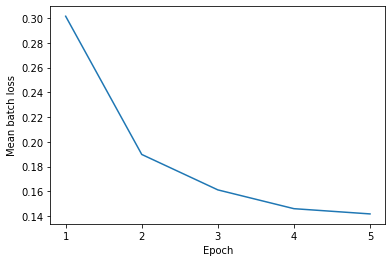

In [ ]:
plt.plot(np.arange(1, 6), loss)
plt.xticks(np.arange(1, 6))
plt.xlabel('Epoch')
plt.ylabel('Mean batch loss')
plt.show()

In [ ]:
train_set.shape[0] / batch_size

16375.0078125

## DistMult

In [ ]:
gm = GraphMiner(dataset, 'cpu', 50, 50)
dm = DistMultModel(gm.num_entities, gm.num_relations, 256)
optimizer = Adam(dm.parameters(), weight_decay=3e-8)
margin = 1
criterion = HingeLoss(margin=margin)
batch_size = 64
num_epochs = 100

In [ ]:
batch = gm.training[:64]
gm.cache_negative_sample(batch, dm)

In [ ]:
for epoch in range(num_epochs):
  train_batches = torch.split(gm.training, batch_size)
  epoch_loss = 0
  for batch in tqdm(train_batches):
    negative = gm.cache_negative_sample(batch, dm)
    epoch_loss += gm.train(dm, (batch, negative), optimizer, criterion)
  print(f'Epoch {epoch}')
  print(epoch_loss)  
  if epoch % 10 == 0:
    print(f'Validation MRR: {gm.MRR(dm, "validation", 64, True)}')

## RESCAL

In [ ]:
rscl = RESCALModel(dataset.num_entities, gm.num_relations, 4).to('cuda')
optm = Adam(rscl.parameters(), 1e-3)

p = train_set[:100].to('cuda')
n = gm.cache_negative_sample(p)
# rscl((p, n))[0]

In [ ]:
for i in range(1000):
  rscl.train()
  p = train_set[:100].to('cuda')
  n = gm.cache_negative_sample(p)
  p_s, n_s = rscl((p, n))
  loss = gm.margin_ranking_loss(p_s, n_s)
  loss.backward()
  optm.step()
  print(loss.item())

In [ ]:
gm.

# One by One Graph Miner

In [ ]:
class OneGM():
  def __init__(self, dataset, device: str, cache_size: int=None, replacement_size: int=None) -> NoReturn:
    self.device = device
    self.dataset = dataset
    self.training = self.dataset.training.to(self.device)
    self.validation = self.dataset.validation.to(self.device)
    self.testing = self.dataset.testing.to(self.device)
    self.candidates = self.dataset.candidates.to(self.device)
    if cache_size and replacement_size:
      self.cache_size = cache_size
      self.replacement_size = replacement_size
      self.head_cache = (torch.rand(dataset.num_relations, entities.shape[0], cache_size) * entities.shape[0] - 1).round().long().to(self.device)
      self.tail_cache = (torch.rand(entities.shape[0], dataset.num_relations, cache_size) * entities.shape[0] - 1).round().long().to(self.device)

    self.num_entities = self.dataset.num_entities
    self.num_relations = self.dataset.num_relations

  def pyg_data(self, index, batch_size, negative_sampler):
    indcs = torch.ones_like(self.training[:, 0], dtype=torch.bool)
    not_include = torch.arange(index, index + batch_size, device=self.device)
    indcs[not_include] = False

    edge_index = self.training[indcs][:, (0, 2)].t().contiguous()
    edge_type = self.training[indcs][:, 1].t().contiguous()
    positive = self.training[index: index + batch_size, :]
    negative = negative_sampler(positive)

    return Data(
        x=self.candidates,
        edge_index=edge_index,
        edge_type=edge_type,
        positive=positive,
        negative=negative
    )

  def uniform_negative_sample(self, triplet, check=False):
    okay = False
    while not okay:
      h, r, t = triplet
      index = torch.round(torch.rand(1) * (self.candidates.shape[0] * 2)).long()
      if index < self.candidates.shape[0]:
        # corrupt head
        negative_triplet = torch.tensor([self.candidates[index], r, t]).to(self.device).reshape(1, 3)
      else:
        # corrupt tail
        index -= self.candidates.shape[0]
        negative_triplet = torch.tensor([h, r, self.candidates[index]]).to(self.device).reshape(1, 3)
      okay = (not check) or (not ((negative_triplet == self.training).sum(-1) == 3).sum())
      return negative_triplet

  def cache_negative_sample(self, triplet, check=False):
    okay = False
    h, r, t = triplet
    index = torch.round(torch.rand(1) * self.cache_size - 1).long()
    h_bar = self.head_cache[r][t][index]
    index = torch.round(torch.rand(1) * self.cache_size - 1).long()
    t_bar = self.tail_cache[h][r][index]
    if torch.rand(1) < 0.5:
      negative_triplet = torch.tensor([h_bar, r, t]).reshape(1, 3).to(self.device)
    else:
      negative_triplet = torch.tensor([h, r, t_bar]).reshape(1, 3).to(self.device)

  def _update_cache(self, triplet, scoring_function, head_or_tail, **kwargs):
    data = triplet
    triplet = data.positive
    h, r, t = triplet

    new_candidates = torch.round(torch.rand(self.replacement_size) * (self.candidates.shape[0] - 1)).long()
    if head_or_tail == 'head':
      all_entities = torch.cat((self.head_cache[r][t], new_candidates)).reshape(-1, 1)
    elif head_or_tail == 'tail':
      all_entities = torch.cat((self.tail_cache[h][r], new_candidates)).reshape(-1, 1)
    if head_or_tail == 'head':
      partial = torch.tensor([r, t]).reshape(1, 2).repeat(self.cache_size + self.replacement_size, 1)
      all_triplets = torch.cat((all_entities, partial), -1)
    elif head_or_tail == 'tail':
      partial = torch.tensor([h, r]).reshape(1, 2).repeat(cache_size + replacement_size, 1)
      all_triplets = torch.cat((partial, all_entities), -1)
    dummy = torch.ones(1, 3).long()
    input = (all_triplets, dummy)
    if kwargs.get('gnn'):
      indcs = torch.ones(self.training.shape[0], dtype=torch.bool)
      indcs[i] = False
      input = Data(
            x=data.x,
            edge_index=data.edge_index,
            edge_type=data.edge_type,
            positive=all_triplets,
            negative=dummy
        )
      
    scoring_function.eval()
    with torch.no_grad():
      scores = scoring_function(input)[0]
    fitness = F.softmax(scores, -1)
    if head_or_tail == 'head':
      self.head_cache[r][t] = all_entities.reshape(-1)[fitness.multinomial(num_samples=self.cache_size, replacement=False)]
    elif head_or_tail == 'tail':
      self.tail_cache[h][r] = all_entities.reshape(-1)[fitness.multinomial(num_samples=self.cache_size, replacement=False)]

  def update_caches(self, batch, scoring_function, **kwargs):
    self._update_cache(batch, scoring_function, 'head', **kwargs)
    self._update_cache(batch, scoring_function, 'tail', **kwargs)

  def train(self, model: Module, data, optimizer: torch.optim, loss_fn, update_cache=False) -> tuple((torch.float, torch.Tensor, torch.Tensor)):
    optimizer.zero_grad()
    model.train()

    positive, negative = model(data) # forward pass

    loss = loss_fn(positive, negative, torch.ones(1).to(self.device)) # margin ranking loss

    loss.backward() # back propagation
    optimizer.step() # parameter updates
    if update_cache:
      self.update_caches(data, model, gnn=True)
    return loss.item()

  @torch.no_grad()
  def _ranks(self, model, batch):
    batch_size = batch.shape[0]

    head_relation = batch[:, (0, 1)].repeat(self.candidates.shape[0], 1)
    relation_tail = batch[:, (1, 2)].repeat(self.candidates.shape[0], 1)

    entities = self.candidates.reshape(-1, 1).repeat(batch_size, 1)
    entities = torch.cat(torch.split(entities, self.candidates.shape[0]), -1).reshape(-1, 1)

    corrupted_head_triplets = torch.cat(
        (entities, relation_tail), 
        -1
    )
    corrupted_tail_triplets = torch.cat(
        (head_relation, entities), 
        -1
    )
    corrupted_head_triplets = torch.cat(torch.split(corrupted_head_triplets, batch_size), -1).reshape(batch_size, -1, 3)
    corrupted_tail_triplets = torch.cat(torch.split(corrupted_tail_triplets, batch_size), -1).reshape(batch_size, -1, 3)

    heads = batch[:, 0]
    tails = batch[:, 2]

    dummy = torch.ones(1, 3).long().to(self.device)

    model.eval()
    head_scores = model(
        (dummy, corrupted_head_triplets.reshape(-1, 3))
    )[1].reshape(batch_size, -1)
    head_ranks = (head_scores.gather(dim=1, index=heads.reshape(-1, 1)) <= head_scores).sum(-1) # Max Policy

    tail_scores = model(
        (dummy, corrupted_tail_triplets.reshape(-1, 3))
    )[1].reshape(batch_size, -1)
    tail_ranks = (tail_scores.gather(dim=1, index=tails.reshape(-1, 1)) <= tail_scores).sum(-1)

    return head_ranks.reshape(-1), tail_ranks.reshape(-1)

  @torch.no_grad()
  def MRR(self, model, set_type, batch_size, use_tqdm=False):
    if set_type == 'validation':
      eval_set = self.validation
    elif set_type == 'testing':
      eval_set = self.testing
    else:
      raise ValueError('Wrong data split specified.')
    
    sum = 0
    size = 0
    wrapper = tqdm if use_tqdm else (lambda z: z)
    for batch in wrapper(torch.split(eval_set, batch_size)):
      head_ranks, tail_ranks = self._ranks(model, batch)
      sum += (1 / head_ranks).sum() + (1 / tail_ranks).sum()
      size += head_ranks.shape[0] + tail_ranks.shape[0]
    return sum / size
      

In [ ]:
gnn = GNN(dataset.num_entities, dataset.num_relations, 32, (32, 32, 32), 0.4)
optimizer = Adam(gnn.parameters())
margin = 1
criterion = MarginRankingLoss(margin)

In [ ]:
def train_one(model, data, criterion, optimizer):
  model.train()
  optimizer.zero_grad()
  p, n = model(data)
  loss = criterion(p, n, torch.ones(1))
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
cache_size = 10
# head_cache = torch.rand(cache_size) * entities.shape[0]
head_cache = (torch.rand(dataset.num_relations, entities.shape[0], cache_size) * entities.shape[0] - 1).round().long()
tail_cache = (torch.rand(entities.shape[0], dataset.num_relations, cache_size) * entities.shape[0] - 1).round().long()

# train_set
# h, r, t = triplet


In [ ]:
# try:
#   for triplet in tqdm(train_set):
#     h, r, t = triplet
#     index = torch.round(torch.rand(1) * cache_size - 1).long()
#     h_bar = head_cache[r][t][index]
#     index = torch.round(torch.rand(1) * cache_size - 1).long()
#     t_bar = tail_cache[h][r][index]
#     if torch.rand(1) < 0.5:
#       negative_triplet = torch.tensor([h_bar, r, t]).reshape(1, 3)
#     else:
#       negative_triplet = torch.tensor([h, r, t_bar]).reshape(1, 3)
# except KeyboardInterrupt:
#   pass
h, r, t = triplet
head_or_tail = 'tail'
i = 0
replacement_size = 10

new_candidates = torch.round(torch.rand(replacement_size) * (entities.shape[0] - 1)).long()
if head_or_tail == 'head':
  all_entities = torch.cat((head_cache[r][t], new_candidates)).reshape(-1, 1)
elif head_or_tail == 'tail':
  all_entities = torch.cat((tail_cache[h][r], new_candidates)).reshape(-1, 1)
if head_or_tail == 'head':
  partial = torch.tensor([r, t]).reshape(1, 2).repeat(cache_size + replacement_size, 1)
  all_triplets = torch.cat((all_entities, partial), -1)
elif head_or_tail == 'tail':
  partial = torch.tensor([h, r]).reshape(1, 2).repeat(cache_size + replacement_size, 1)
  all_triplets = torch.cat((partial, all_entities), -1)
dummy = torch.ones(1, 3).long()
input = (all_triplets, dummy)
kwargs = {}
if True or kwargs.get('gnn'):
  indcs = torch.ones(train_set.shape[0], dtype=torch.bool)
  indcs[i] = False
  input = Data(
        x=entities,
        edge_index=train_set[indcs][:, (0, 2)].t().contiguous(),
        edge_type=train_set[indcs][:, 1].t().contiguous(),
        positive=all_triplets,
        negative=dummy
    )
  
gnn.eval()
with torch.no_grad():
  scores = gnn(input)[0]
fitness = F.softmax(scores, -1)
if head_or_tail == 'head':
  head_cache[r][t] = all_entities.reshape(-1)[fitness.multinomial(num_samples=cache_size, replacement=False)]
elif head_or_tail == 'tail':
  tail_cache[h][r] = all_entities.reshape(-1)[fitness.multinomial(num_samples=cache_size, replacement=False)]

torch.Size([20, 1])

In [ ]:
try:
  for i, triplet in tqdm(enumerate(train_set)):
    okay = False
    while not okay:
      h, r, t = triplet
      index = torch.round(torch.rand(1) * (entities.shape[0] * 2)).long()
      if index < entities.shape[0]:
        # corrupt head
        negative_triplet = torch.tensor([entities[index], r, t]).reshape(1, 3)
      else:
        # corrupt tail
        index -= entities.shape[0]
        negative_triplet = torch.tensor([h, r, entities[index]])
      # okay = not ((negative_triplet == train_set).sum(-1) == 3).sum()
      okay = True

    indcs = torch.ones(train_set.shape[0], dtype=torch.bool)
    indcs[i] = False
    train_data = Data(
        x=entities,
        edge_index=train_set[indcs][:, (0, 2)].t().contiguous(),
        edge_type=train_set[indcs][:, 1].t().contiguous(),
        positive=triplet.reshape(1, 3),
        negative=negative_triplet.reshape(1, 3)
    )
    print(train_one(gnn, train_data, criterion, optimizer))
    # break

except KeyboardInterrupt:
  pass

1it [00:13, 13.59s/it]

0.0


2it [00:25, 12.79s/it]

2.4341979026794434


3it [00:38, 12.52s/it]

10.070107460021973


3it [00:39, 13.27s/it]


In [ ]:
MarginRankingLoss()()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Evaluation Metric

In [ ]:
#@title find_start_and_end_indcs() PRIVATE-FUNCTION { form-width: "15%" }
def find_start_and_end_indcs(entity, relation, entity_type, kg_sorted):
  up = kg_sorted.shape[0]
  down = 0
  indx = kg_sorted.shape[0] // 2
  found = False
  while up - down > 1:
    if kg_sorted[indx][entity_type].item() == entity:
      found = True
      break 
    elif kg_sorted[indx][entity_type].item() >= entity: 
      up = indx
      indx = (up + down) // 2
    else:
      down = indx 
      indx = (up + down) // 2
  if not found:
    return None
  while 1:
    indx += 1
    try:
      if not kg_sorted[indx][entity_type].item() == entity:
        indx -= 1
        end_indx = indx
        break
    except:
      end_indx = indx - 1
      break
  

  while 1:
    indx -= 1
    try:
      if not kg_sorted[indx][entity_type].item() == entity:
        indx += 1
        start_indx = indx
        break
    except:
      start_indx = indx + 1
      break
  indcs = torch.arange(start_indx, end_indx + 1)
  tns = kg_sorted[indcs]
  srt_indcs = torch.sort(tns[:, 1])[1]

  msk = tns[srt_indcs][:, 1] == relation
  okay_indcs = torch.nonzero(msk).reshape(-1)
  return indcs[srt_indcs[okay_indcs]]

In [ ]:
#@title get_psuedo_negative_entities() FUNCTIONS { form-width: "15%" }
def get_psuedo_negative_entities(entity, relation, corrupt_at, kg_sorted):
  if corrupt_at == Global.HEAD_INDEX.value:
    entity_type = Global.TAIL_INDEX.value 
  elif corrupt_at == Global.TAIL_INDEX.value:
    entity_type = Global.HEAD_INDEX.value

  indcs = find_start_and_end_indcs(entity, relation, entity_type, kg_sorted=kg_sorted)
  
  if indcs is not None:
    fact_triplets_entities = kg_sorted[indcs][:, corrupt_at]
    features_copy = features.detach().clone()
    features_copy[fact_triplets_entities] = -1
    non_negative_mask = features_copy >= 0
    ret = torch.nonzero(non_negative_mask).reshape(-1)
    return ret
  else:
    return features.to(Global.DEVICE.value)

In [ ]:
#@title evaluation_rank() PRIVATE-FUNCTION { form-width: "10%" }
@torch.no_grad()
def evaluation_rank(model, eval_set, messaging_set):
  h_pred_top10 = list()
  t_pred_top10 = list()

  for eval_triplet in tqdm(eval_set):
    #use tqdm
    head = eval_triplet[Global.HEAD_INDEX.value].item()
    relation = eval_triplet[Global.RELATION_INDEX.value].item()
    tail = eval_triplet[Global.TAIL_INDEX.value].item()

    corrupted_tails = get_psuedo_negative_entities(
        entity=head, 
        corrupt_at=Global.TAIL_INDEX.value, 
        kg_sorted=kg_sorted_heads
    )
    
    num_psuedo_negative_triples = corrupted_tails.shape[0]
    psuedo_negative_triplets_corrupted_tail = torch.vstack(
        (
            torch.ones(num_psuedo_negative_triples).to(Global.DEVICE.value).type(torch.long) * head,
            torch.ones(num_psuedo_negative_triples).to(Global.DEVICE.value).type(torch.long) * relation,
            corrupted_tails
        )
    ).t().to(Global.DEVICE.value)

    corrupted_heads = get_psuedo_negative_entities(
        entity=tail, 
        corrupt_at=Global.HEAD_INDEX.value, 
        kg_sorted=kg_sorted_tails
    )

    num_psuedo_negative_triples = corrupted_heads.shape[0]
    psuedo_negative_triplets_corrupted_head = torch.vstack(
        (
            corrupted_heads,
            torch.ones(num_psuedo_negative_triples).to(Global.DEVICE.value).type(torch.long) * relation,
            torch.ones(num_psuedo_negative_triples).to(Global.DEVICE.value).type(torch.long) * tail
        )
    ).t().to(Global.DEVICE.value)

    # eval_triplet: (h, r, t)
    # psuedo_negative_triplets_head: (h′, r, t) for all h′
    # psuedo_negative_triplets_tail: (h, r, t′) for all t′

    # train_set being the messaging graph, calculate the score for (h, r, t)
    # train_set being the messaging graph, calculate the scores for all (h′, r, t)
    # train_set being the messaging graph, calculate the scores for all (h, r, t′)

    graph_data_for_object_tail = graph_data_maker(
      messaging=messaging_set,
      supervision=eval_triplet.reshape(1, 3),
      negative_samples=psuedo_negative_triplets_corrupted_tail,
      x=features.to(Global.DEVICE.value),
      x_feature='one-hot'
    )

    graph_data_for_object_head = graph_data_maker(
            messaging=messaging_set,
            supervision=eval_triplet.reshape(1, 3),
            negative_samples=psuedo_negative_triplets_corrupted_head,
            x=features.to(Global.DEVICE.value),
            x_feature='one-hot'
    )

    model.eval()
    scores_for_object_tail = torch.cat(model(graph_data_for_object_tail))

    sorted_by_scores_for_object_tail_indcs = torch.sort(scores_for_object_tail, descending=True)[1]

    tail_objects = torch.cat((graph_data_for_object_tail.edge_index_supervision[1], graph_data_for_object_tail.edge_index_negative[1]))
    top10_tails = tail_objects[sorted_by_scores_for_object_tail_indcs[:10]]
    t_pred_top10.append(top10_heads)

    model.eval()
    scores_for_object_head = torch.cat(model(graph_data_for_object_head))

    sorted_by_scores_for_object_head_indcs = torch.sort(scores_for_object_head, descending=True)[1]

    head_objects = torch.cat((graph_data_for_object_head.edge_index_supervision[0], graph_data_for_object_head.edge_index_negative[0]))
    top10_heads = head_objects[sorted_by_scores_for_object_head_indcs[:10]]
    h_pred_top10.append(top10_tails)

    # print('')
    ############################################################################## 1
    # if False:
    #   hit_index = (
    #             tail_objects[sorted_by_scores_for_object_head_indcs[:500]] == eval_triplet[2]
    #           ).nonzero(as_tuple=True)[0] + 1
    #   if hit_index.shape[0]:
    #     print(f'Tail ranked at {hit_index.item()}')
    #     print('-' * 30)
    # ############################################################################### 2

    # ############################################################################### 3
    # hit_index = (
    #             head_objects[sorted_by_scores_for_object_tail_indcs[:500]] == eval_triplet[0]
    #           ).nonzero(as_tuple=True)[0] + 1
    # if hit_index.shape[0]:
    #   print(f'Head ranked at {hit_index.item()}')
    #   print('-' * 30)
    ############################################################################## 4
    
  model.train()
  return torch.stack(h_pred_top10), torch.stack(t_pred_top10)

In [ ]:
#@title evaluate_hits_at_10(model, mode) FUNCTION{ form-width: "15%" }
def evaluate_hits_at_10(model: GNN, mode:str) -> torch.float:
  if mode == 'validation':
    head_objects_top10, tail_objects_top10 = evaluation_rank(model, val_set, train_set)
    return evaluator.eval(
            head_objects_top10,
            tail_objects_top10,
            val_set,
            False
    )
  elif mode == 'testing':
    head_objects_top10, tail_objects_top10 = evaluation_rank(model, test_set, torch.cat((train_set, val_set), dim=0))
    return evaluator.eval(
            head_objects_top10,
            tail_objects_top10,
            test_set,
            False
          )
